In [ ]:
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from amftrack.pipeline.functions.image_processing.node_id import remove_spurs
from amftrack.pipeline.functions.image_processing.extract_skel import remove_component, remove_holes
import numpy as np
from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import *
from scipy import signal
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)
from scipy.interpolate import griddata

from skimage.morphology import skeletonize
from amftrack.util.sys import temp_path
import pandas as pd
from PIL import Image
from scipy.optimize import curve_fit
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)



In [ ]:

images_path = r"F:/AMOLF_Data/STORAGE/20221109_Plate462_04"
# images_path = r"/mnt/sun/home-folder/cargill/20221109_Plate462/20221109_Plate462_006"
fps = 20
time_pixel_size = 1/fps #s.pixel
binning = 2
magnification = 50
space_pixel_size = 2*1.725/(magnification)*binning #um.pixel
video_name = images_path.split('/')[-1]
kymos_path = '/'.join(images_path.split('/')[:-1]+["_".join((video_name,'kymos'))])
if not os.path.exists(kymos_path):
    os.mkdir(kymos_path)
files = os.listdir(images_path)
images_total_path = [os.path.join(images_path,file) for file in files]
images_total_path.sort()



In [ ]:

selection_file = images_total_path
selection_file.sort()
begin  = 1
end = -1
image = imageio.imread(selection_file[end])
image2 = imageio.imread(selection_file[begin])
selection_file = selection_file[begin:end]

fig, ax = plt.subplots()
ax.imshow(image,cmap="gray")
ax.imshow(image2,alpha = 0.5)


segmented,nx_graph_pruned,pos = segment_fluo(image,thresh = 5e-07)
fig, ax = plt.subplots()
ax.imshow(segmented,cmap="gray")

fig, ax = plt.subplots()
ax.imshow(image)
weight = 0.05
for edge in list(nx_graph_pruned.edges):
    ax.text(*np.flip((1-weight) * pos[edge[0]]+weight*pos[edge[1]]),str(edge[0]),color="white")
    ax.text(*np.flip((1-weight) * pos[edge[1]]+weight*pos[edge[0]]),str(edge[1]),color="white")

edges = list(nx_graph_pruned.edges)
edge_oriented = []
for edge in edges:
    if pos[edge[0]][0]>pos[edge[1]][0]:
        edge_oriented.append(edge)
    else:
        edge_oriented.append((edge[1],edge[0]))
edges = edge_oriented

edge_oriented

np.linalg.norm(pos[edge[0]]-pos[edge[1]])

fig, ax = plt.subplots()
ax.imshow(image)


In [ ]:
bound1 = 0
bound2 = 1
step=30
target_length=130
resolution = 1
for edge in edges:
    offset=int(np.linalg.norm(pos[edge[0]]-pos[edge[1]]))//4
    slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    image,
    nx_graph_pruned,
    resolution=resolution,
    offset=offset,
    step=step,
    target_length=target_length,
    bound1=bound1,
    bound2=bound2
)
    # plot_segments_on_image(segments,ax,color=None)
    plot_segments_on_image(segments,ax, bound1=bound1,
    bound2=bound2,color = 'white',alpha = 0.1)
    ax.plot([pos[edge[0]][1],pos[edge[1]][1]],[pos[edge[0]][0],pos[edge[1]][0]])
    ax.text(*np.flip((1-weight) * pos[edge[0]]+weight*pos[edge[1]]),str(edge[0]),color="white")
    ax.text(*np.flip((1-weight) * pos[edge[1]]+weight*pos[edge[0]]),str(edge[1]),color="white")
save_path_temp = os.path.join(kymos_path, f"extraction.png")
plt.savefig(save_path_temp)


In [ ]:

kymos = {edge:get_kymo(edge,pos,selection_file,nx_graph_pruned, resolution=1,
    offset=offset,
    step=step,
    target_length=target_length,
    bound1=bound1,
    bound2=bound2) for edge in edges}



In [ ]:

filtered_kymos = {edge: filter_kymo(kymos[edge]) for edge in edges}
speeds = {}
for edge in kymos.keys():
    kymo = kymos[edge]
    save_path_temp = os.path.join(kymos_path, f"{edge}kymo.npy")
    np.save(save_path_temp,kymo)
    im = Image.fromarray(kymo.astype(np.uint8))
    save_path_temp = os.path.join(kymos_path, f"{edge}kymo.png")
    im.save(save_path_temp)

for edge in kymos.keys():
    for i in [0,1]:
        kymo = filtered_kymos[edge][i]
        suffix = 'right' if i==0 else "left"
        save_path_temp = os.path.join(kymos_path, f"{edge}kymo_{suffix}.npy")
        np.save(save_path_temp,kymo)
        im = Image.fromarray(((kymo-np.min(kymo))/np.max(kymo)*128).astype(np.uint8))
        save_path_temp = os.path.join(kymos_path, f"{edge}kymo_{suffix}.png")
        im.save(save_path_temp)

fig, ax = plt.subplots()
speed_dataframe = pd.DataFrame()
for j,edge in enumerate(edges):
    for i in [0,1]:
        kymo = filter_kymo(kymos[edge])[i]
        W = int(5/space_pixel_size)          # window size is WxW
        W = 3
        C_Thr = 0.95
        imgCoherency, imgOrientation = calcGST(kymo, W)
        nans = np.empty(imgOrientation.shape)
        nans.fill(np.nan)
        real_movement = np.where(imgCoherency>C_Thr,imgOrientation,nans)
        speed=np.tan((real_movement-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
        nans = np.empty(speed.shape)
        nans.fill(np.nan)
        speed = np.where(speed<20,speed,nans)
        nans = np.empty(speed.shape)
        nans.fill(np.nan)
        speed = np.where(speed>-20,speed,nans)
        # # ax.imshow((imgCoherency))
        klen = 25
        kernel = np.ones((klen,klen))/klen**2
        z1 = scipy.signal.convolve2d(imgCoherency, kernel,mode = "same")
        nans = np.empty(speed.shape)
        nans.fill(np.nan)
        speed = np.where(z1>0.8,speed,nans)
        label =edge if i==0 else None
        times = np.array(range(len(np.mean(speed,axis=1))))*time_pixel_size
        speeds = np.nanmean(speed,axis=1)
        edges_list = [edge for k in range(len(speeds))]
        direction = ["root" if i==0 else 'tip' for k in range(len(speeds))]
        data = pd.DataFrame(np.transpose((times,speeds,edges_list,direction)),
                     columns = ['time (s)','speed (um.s-1)','edge','direction'])
        speed_dataframe = pd.concat((speed_dataframe,data))
        p = ax.plot(times,speeds,label =edge if i==0 else None,color=None if i==0 else color)
        color = p[0].get_color()
        ax.set_ylabel('speed($\mu m.s^{-1}$)')
        ax.set_xlabel('time ($s$)')
save_path_temp = os.path.join(kymos_path, f"speed_data.csv")
speed_dataframe.to_csv(save_path_temp)
plt.legend()
plt.tight_layout()


C:\Users\night\AppData\Local\Temp\ipykernel_15636\1900220872.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[end])
C:\Users\night\AppData\Local\Temp\ipykernel_15636\1900220872.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread(selection_file[begin])


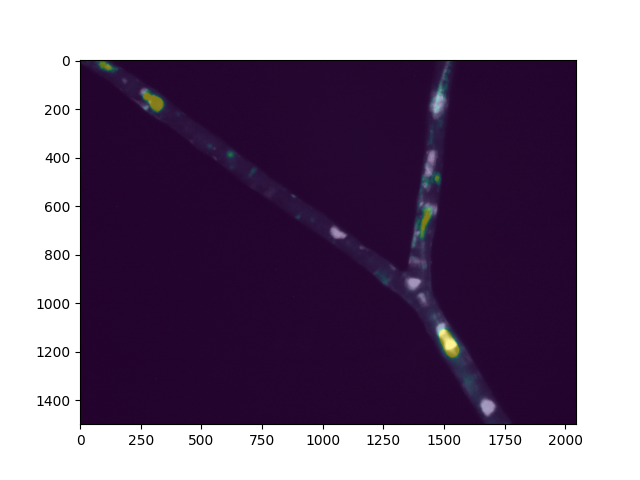

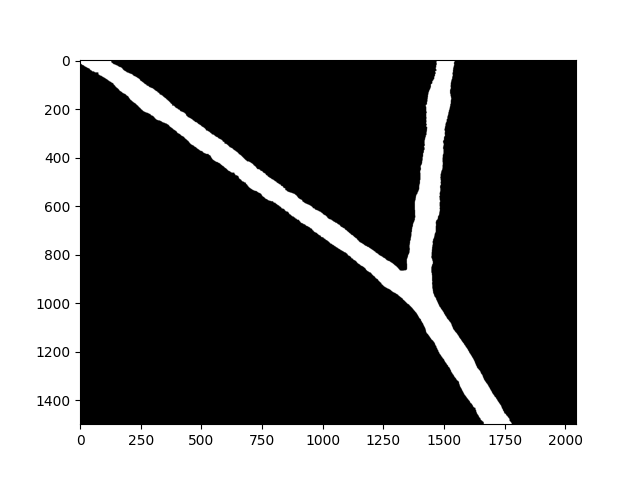

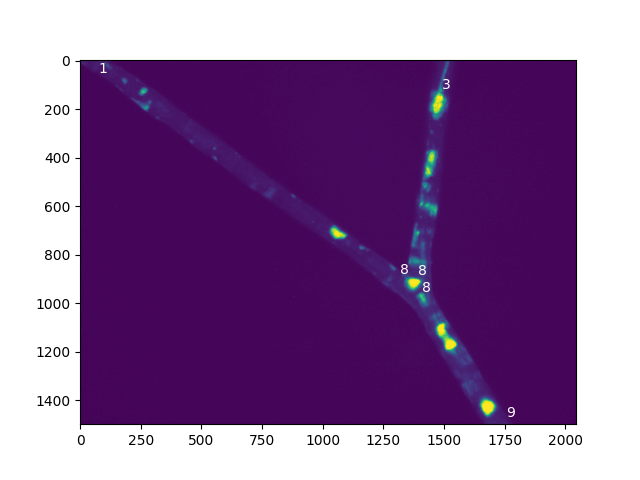

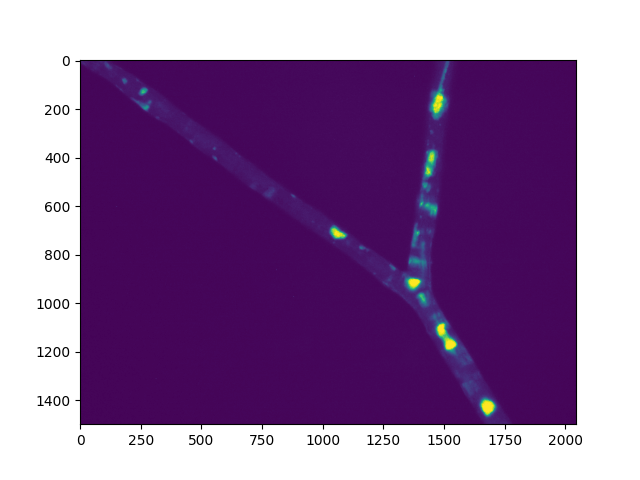

In [6]:

selection_file = images_total_path
selection_file.sort()
begin  = 1
end = -1
image = imageio.imread(selection_file[end])
image2 = imageio.imread(selection_file[begin])
selection_file = selection_file[begin:end]

fig, ax = plt.subplots()
ax.imshow(image,cmap="gray")
ax.imshow(image2,alpha = 0.5)


segmented,nx_graph_pruned,pos = segment_fluo(image,thresh = 5e-07)
fig, ax = plt.subplots()
ax.imshow(segmented,cmap="gray")

fig, ax = plt.subplots()
ax.imshow(image)
weight = 0.05
for edge in list(nx_graph_pruned.edges):
    ax.text(*np.flip((1-weight) * pos[edge[0]]+weight*pos[edge[1]]),str(edge[0]),color="white")
    ax.text(*np.flip((1-weight) * pos[edge[1]]+weight*pos[edge[0]]),str(edge[1]),color="white")

edges = list(nx_graph_pruned.edges)
edge_oriented = []
for edge in edges:
    if pos[edge[0]][0]>pos[edge[1]][0]:
        edge_oriented.append(edge)
    else:
        edge_oriented.append((edge[1],edge[0]))
edges = edge_oriented

edge_oriented

np.linalg.norm(pos[edge[0]]-pos[edge[1]])

fig, ax = plt.subplots()
ax.imshow(image)


In [7]:
bound1 = 0
bound2 = 1
step=30
target_length=130
resolution = 1
for edge in edges:
    offset=int(np.linalg.norm(pos[edge[0]]-pos[edge[1]]))//4
    slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    image,
    nx_graph_pruned,
    resolution=resolution,
    offset=offset,
    step=step,
    target_length=target_length,
    bound1=bound1,
    bound2=bound2
)
    # plot_segments_on_image(segments,ax,color=None)
    plot_segments_on_image(segments,ax, bound1=bound1,
    bound2=bound2,color = 'white',alpha = 0.1)
    ax.plot([pos[edge[0]][1],pos[edge[1]][1]],[pos[edge[0]][0],pos[edge[1]][0]])
    ax.text(*np.flip((1-weight) * pos[edge[0]]+weight*pos[edge[1]]),str(edge[0]),color="white")
    ax.text(*np.flip((1-weight) * pos[edge[1]]+weight*pos[edge[0]]),str(edge[1]),color="white")
save_path_temp = os.path.join(kymos_path, f"extraction.png")
plt.savefig(save_path_temp)


In [ ]:

kymos = {edge:get_kymo(edge,pos,selection_file,nx_graph_pruned, resolution=1,
    offset=offset,
    step=step,
    target_length=target_length,
    bound1=bound1,
    bound2=bound2) for edge in edges}



In [ ]:

filtered_kymos = {edge: filter_kymo(kymos[edge]) for edge in edges}
speeds = {}
for edge in kymos.keys():
    kymo = kymos[edge]
    save_path_temp = os.path.join(kymos_path, f"{edge}kymo.npy")
    np.save(save_path_temp,kymo)
    im = Image.fromarray(kymo.astype(np.uint8))
    save_path_temp = os.path.join(kymos_path, f"{edge}kymo.png")
    im.save(save_path_temp)

for edge in kymos.keys():
    for i in [0,1]:
        kymo = filtered_kymos[edge][i]
        suffix = 'right' if i==0 else "left"
        save_path_temp = os.path.join(kymos_path, f"{edge}kymo_{suffix}.npy")
        np.save(save_path_temp,kymo)
        im = Image.fromarray(((kymo-np.min(kymo))/np.max(kymo)*128).astype(np.uint8))
        save_path_temp = os.path.join(kymos_path, f"{edge}kymo_{suffix}.png")
        im.save(save_path_temp)

fig, ax = plt.subplots()
speed_dataframe = pd.DataFrame()
for j,edge in enumerate(edges):
    for i in [0,1]:
        kymo = filter_kymo(kymos[edge])[i]
        W = int(5/space_pixel_size)          # window size is WxW
        W = 3
        C_Thr = 0.95
        imgCoherency, imgOrientation = calcGST(kymo, W)
        nans = np.empty(imgOrientation.shape)
        nans.fill(np.nan)
        real_movement = np.where(imgCoherency>C_Thr,imgOrientation,nans)
        speed=np.tan((real_movement-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
        nans = np.empty(speed.shape)
        nans.fill(np.nan)
        speed = np.where(speed<20,speed,nans)
        nans = np.empty(speed.shape)
        nans.fill(np.nan)
        speed = np.where(speed>-20,speed,nans)
        # # ax.imshow((imgCoherency))
        klen = 25
        kernel = np.ones((klen,klen))/klen**2
        z1 = scipy.signal.convolve2d(imgCoherency, kernel,mode = "same")
        nans = np.empty(speed.shape)
        nans.fill(np.nan)
        speed = np.where(z1>0.8,speed,nans)
        label =edge if i==0 else None
        times = np.array(range(len(np.mean(speed,axis=1))))*time_pixel_size
        speeds = np.nanmean(speed,axis=1)
        edges_list = [edge for k in range(len(speeds))]
        direction = ["root" if i==0 else 'tip' for k in range(len(speeds))]
        data = pd.DataFrame(np.transpose((times,speeds,edges_list,direction)),
                     columns = ['time (s)','speed (um.s-1)','edge','direction'])
        speed_dataframe = pd.concat((speed_dataframe,data))
        p = ax.plot(times,speeds,label =edge if i==0 else None,color=None if i==0 else color)
        color = p[0].get_color()
        ax.set_ylabel('speed($\mu m.s^{-1}$)')
        ax.set_xlabel('time ($s$)')
save_path_temp = os.path.join(kymos_path, f"speed_data.csv")
speed_dataframe.to_csv(save_path_temp)
plt.legend()
plt.tight_layout()
